# Global Imports

In [1]:
from os import path
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots

# Torch imports for model
import torch
import torch.optim as optim
import torch.nn as nn



# ISLP Functions Import
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)

# Plotting
from utils.plot_functions import plot_data, plot_loss, plot_line_on_data

#Stats
from utils.stat_functions import simple_linear_regression_summary

# Task 8
perform a simple linear regression
with mpg as the response and horsepower as the predictor.

## Importing a Data

In [2]:
# impoerting data
Data = pd.read_csv(path.join("data", "Auto.csv"))
Data[0:5]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


## Data Peparation

In [3]:
X = np.array(Data['horsepower'], dtype=float)
Y = np.array(Data['mpg'], dtype=float)

## Spliting and Plotting a data

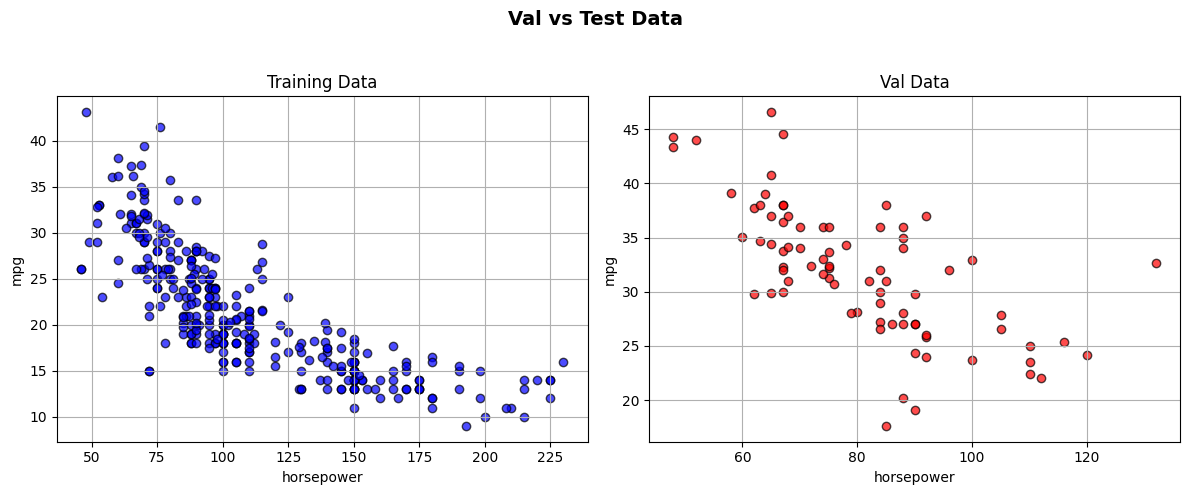

In [4]:
N = len(X)

#indexes
idx = np.arange(len(X))
train_idx = idx[:int(N*.8)]
val_idx = idx[int(N*0.8):]

#Predictor and Response
x_train, y_train = X[train_idx], Y[train_idx]
x_val, y_val = X[val_idx], Y[val_idx]

#Ploting a data
plot_data(x_train, y_train, x_val, y_val, xlabel="horsepower", ylabel="mpg")

## Preparing a dataset for gpu computation

In [5]:
# device import
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# randomizer set
torch.manual_seed(42)

# Create tensor for gpu
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)
x_val_tensor = torch.from_numpy(x_val).float().to(device)
y_val_tensor = torch.from_numpy(y_val).float().to(device)

# normalizing input
x_train_tensor = x_train_tensor / x_train_tensor.max()
y_train_tensor = y_train_tensor / y_train_tensor.max()



cuda


## Creating a model

$$
Y = b + w \times X + \epsilon
$$
We will create a simple regression model via pytroch

In [6]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.b = nn.Parameter(torch.randn(1,
                                          requires_grad=True,
                                          dtype=torch.float))
        
        self.w = nn.Parameter(torch.randn(1,
                                          requires_grad=True,
                                          dtype=torch.float))

    def forward(self, x):
        y = self.b + self.w*x
        
        return y

model = LinearRegression().to(device)
print(model.state_dict())

OrderedDict([('b', tensor([0.3367], device='cuda:0')), ('w', tensor([0.1288], device='cuda:0'))])


## Adjusting a hyperparamters, criterion and optimizer

In [7]:
# Hyperparamters
lr = 0.1
epochs = 1000

optimizer = optim.SGD(model.parameters(), lr=lr)
print(optimizer)

criterion = nn.MSELoss(reduction='mean')
print(criterion)



SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
MSELoss()


## Traing Loop

OrderedDict([('b', tensor([0.8310], device='cuda:0')), ('w', tensor([-0.6995], device='cuda:0'))])


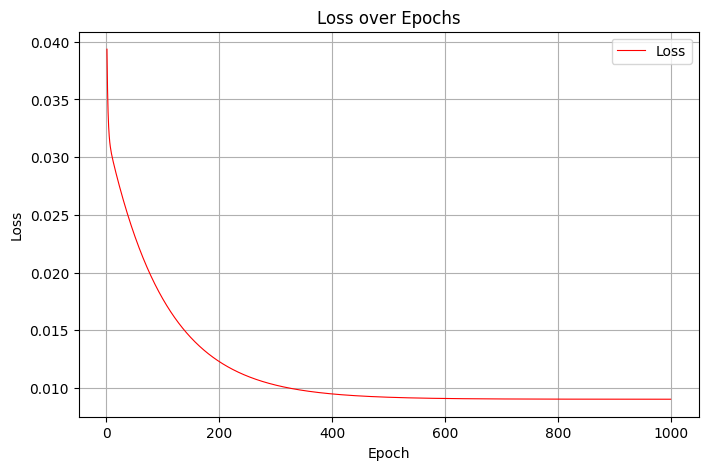

In [8]:
losses = [] # Yo for keeping track of loss

## In need of fixinbg

for i in range(epochs):
    model.train() # what bro it is not relly training model?
    
    y_pred = model(x_train_tensor) # Don't use foward U will use da hooks
    
    loss = criterion(y_pred, y_train_tensor)
    
    losses.append(float(loss))
    
    loss.backward() # calculate da gradients
    
    optimizer.step() # update the parameters
    optimizer.zero_grad()


print(model.state_dict())
plot_loss(losses) #Plotting loss

## Testing Model Predictiom

### model prediction and statistic

In [9]:
#Normalize val tensors
x_val_tensor /= x_val_tensor.max()
y_val /= y_val.max()

#Make prediction
model.eval()
y_pred_tensor=model(x_val_tensor)

# move to numpy
y_pred=(y_pred_tensor.detach().cpu().numpy())

b_t,w_t = model.parameters()
b, w = b_t.detach().cpu().numpy(), w_t.detach().cpu().numpy()

simple_linear_regression_summary(w,b,x_val,y_val,y_pred)

,Parameter,Estimate,Std. Error,t-Statistic,p-Value
0,Weight,-0.699511,0.002014,-347.247864,0.000000
1,Bias,0.830973,0.165509,5.020710,0.000003


### Ploting train data set

/tmp/ipykernel_30630/1704318488.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w = float(w)
/tmp/ipykernel_30630/1704318488.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  b = float(b)


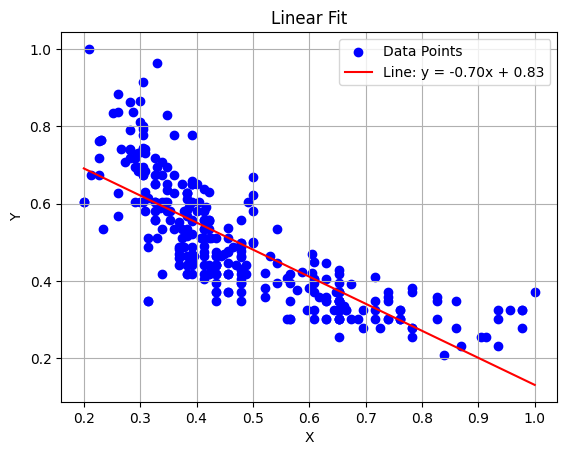

In [10]:
w = float(w)
b = float(b)

#normalization
x_train_n = x_train/x_train.max()
y_train_n = y_train/y_train.max()

plot_line_on_data(x_train_n, y_train_n, w,b)

### Ploting val data set

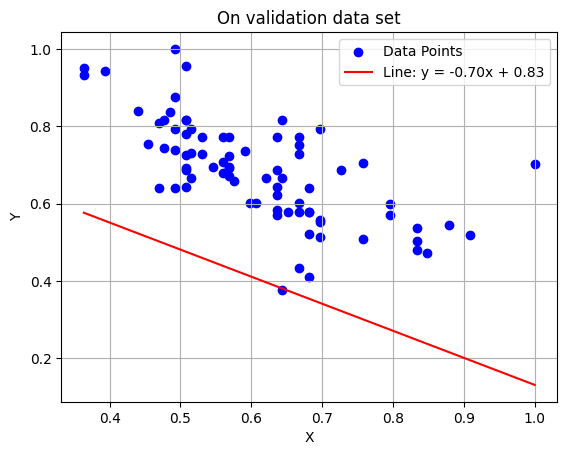

In [11]:
# Normalization
x_val_n = x_val/x_val.max()
y_val_n = y_val/y_val.max()

plot_line_on_data(x_val_n, y_val_n, w,b, title="On validation data set")

## Better model

In [12]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.b = nn.Parameter(torch.randn(1,
                                          requires_grad=True,
                                          dtype=torch.float))
        
        self.w1 = nn.Parameter(torch.randn(1,
                                          requires_grad=True,
                                          dtype=torch.float))

        self.w2 = nn.Parameter(torch.randn(1,
                                          requires_grad=True,
                                          dtype=torch.float))

    def forward(self, x):
        y = self.b + self.w1*x + self.w2*x**2
        
        return y

model = LinearRegression().to(device)
print(model.state_dict())

OrderedDict([('b', tensor([0.2345], device='cuda:0')), ('w', tensor([0.2303], device='cuda:0'))])


In [13]:
### Training

OrderedDict([('b', tensor([-1.1229], device='cuda:0')), ('w1', tensor([-0.1863], device='cuda:0')), ('w2', tensor([2.2082], device='cuda:0'))])
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
MSELoss()
OrderedDict([('b', tensor([0.9753], device='cuda:0')), ('w1', tensor([-1.2965], device='cuda:0')), ('w2', tensor([0.5456], device='cuda:0'))])


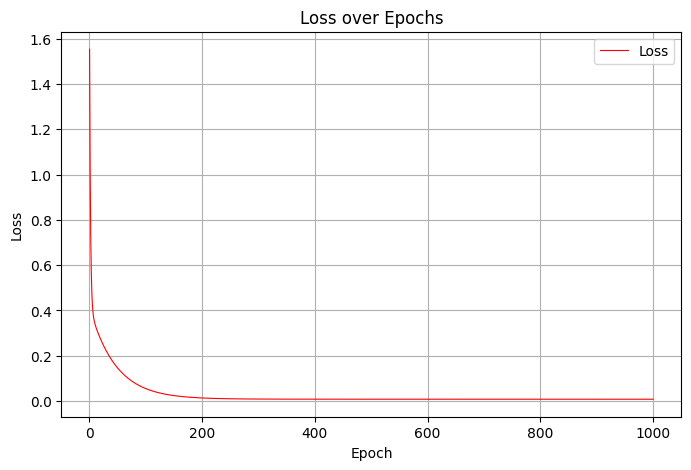

In [14]:
model = MyModel().to(device)
print(model.state_dict())

# Hyperparamters
lr = 0.1
epochs = 1000

optimizer = optim.SGD(model.parameters(), lr=lr)
print(optimizer)

criterion = nn.MSELoss(reduction='mean')
print(criterion)

losses = [] # Yo for keeping track of loss

## In need of fixinbg

for i in range(epochs):
    model.train() # what bro it is not relly training model?
    
    y_pred = model(x_train_tensor) # Don't use foward U will use da hooks
    
    loss = criterion(y_pred, y_train_tensor)
    
    losses.append(float(loss))
    
    loss.backward() # calculate da gradients
    
    optimizer.step() # update the parameters
    optimizer.zero_grad()


print(model.state_dict())
plot_loss(losses) #Plotting loss

### Ploting on a Train Data Set

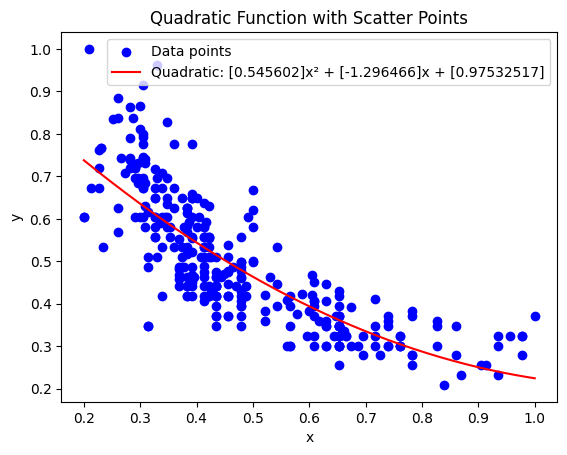

In [16]:
from utils.plot_functions import plot_quadratic

b_t,w1_t,w2_t = model.parameters()
b, w1, w2 = b_t.detach().cpu().numpy(), w1_t.detach().cpu().numpy(), w2_t.detach().cpu().numpy()


plot_quadratic(w2,w1,b,x_train_n, y_train_n)

### Plot on a val Data Set

In [ ]:
plot_quadratic(w2,w1,b,x_val_n, y_val_n)